NB: la cartella Nuovi-MD contiene il file md.trr e md.xtc, troppo grandi per essere caricati su github. Perciò se anche voi volete eseguire il codic, vi consiglio di crearlo in locale

# IMPORT DELLE LIBRERIE

In [4]:
import sys
import argparse
import warnings
import os
import fileinput
import glob
import shutil
import subprocess
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import matplotlib.pyplot as plt
%matplotlib inline

Creazione delle cartelle per il salvataggio dei risultati

In [ ]:
#!mkdir risultati #Cartella per raccolgiere i risultati
#!mkdir md-sim #Cartella per raccolgiere i log

# SIMULAZIONE

Funzioni da importare dal file Gromacs_Tools, ma visto che per ora non sappiamo farlo, le definiamo in questo slot

In [11]:
%run Gromacs_Tools.py

<Figure size 640x480 with 0 Axes>

Import dello script Gromacs_Tools.py contenente le funzioni per eseguire i comandi di Gromacs

In [13]:
import Gromacs_Tools

# SuMD

Inizializzazione dei parametri

In [6]:
m = 0 # threshold of the angular coefficient values of the straight line that interpolates the saved points
t_max = 31 # maximum threshold of bankruptcy attempts granted in the preliminary run
counter1t = 17 # maximum threshold of failed attempts granted in the SuMD run
ct02 = 19 # threshold relating to the times in which the distance between the com is between 0 and 2 Å during the final phase of unsupervised MD
ct25 = 19 # threshold relating to the times in which the distance between the com is between 2 and 5 Å during the final phase of unsupervised MD
ct59 = 19 # threshold relating to the times in which the distance between the com is between 5 and 9 Å during the final phase of unsupervised MD

#Inizializzazione
m_pirmo = 0 # value of the angular coefficient of the line which is updated and compared with m each short MD simulation
t_step = 1 # counter that is increased by 1 and compared with t_max every time there is a failed step in the preliminary run
counter1 = 0 # counter that is incremented by 1 and compared with counter1t every time there is a failed step in the SuMD run
c_step = 0 # counters that allow us to determine when a SuMD run step is productive
k_step = 0 # counters that allow us to determine when a SuMD run step is productive
d_cm_vector = np.zeros(5) # vector in which the distances of the com taken in the 5 steps are entered within each short MD simulation during the SuMD run
d_cm_out = 0 # final distance value 𝑑𝑐𝑚 stored at the end of the short MD simulations that occur once supervision is stopped
counter02 = 0 # counter that is updated and compared with ct02 every time that 𝑑𝑐𝑚𝑜𝑢𝑡 is between 0 and 2 Å
counter25 = 0 # counter that is updated and compared with ct25 every time that 𝑑𝑐𝑚𝑜𝑢𝑡 is between 2 and 5 Å
counter59 = 0 # counter that is updated and compared with ct59 every time that 𝑑𝑐𝑚𝑜𝑢𝑡 is between 5 and 9 Å

In [7]:
def Linear_Fitting(PDB,XTC,n,frame_rate): #Funzione per il fitting lineare
  
  #Check dei file
  if os.stat(PDB).st_size == 0: #check PDB file
    print('Il file PDB è vuoto')
    return
  
  if os.stat(XTC).st_size == 0: #check XTC file
    print('Il file XTC è vuoto')
    return

  u = mda.Universe(PDB,XTC) #universe creation
  protein = u.select_atoms('protein')
  LIG = u.select_atoms('resname LIG')

  print(f"Lunghezza di u.trajectory: {len(u.trajectory)}")
  print(f"Numero di frame di u.trajectory: {u.trajectory.n_frames}")

  step = frame_rate/(int(n)-1) #calculate how many steps of the trajectory will be analyzed (used as integer)
  #print(step) #debug
  d = np.empty(len(u.trajectory[:frame_rate:int(step)]), dtype=float) #distance vector

  p = 0 #aux variable for vector indexing
  len(u.trajectory)
  for ts in u.trajectory[:frame_rate:int(step)]: #trajectory analysis cycle
    d[p] = float(distances.distance_array(np.array(protein.center_of_mass()),np.array(LIG.center_of_mass())))
    p += 1

  x = np.linspace(0,600,int(n), dtype=float) #x-axis time reference

  print(f"Lunghezza di x: {len(x)} - x: {x}")
  print(f"Lunghezza di y: {len(d.astype(np.float32))} - y: {d.astype(np.float32)}")

  m1 = np.polyfit(x,d.astype(np.float32),1) #linear fitting of distance vector

  print('\nVorresti visualizzare anche la curva non fittata? Se si premi 1, altrimenti premi un tasto qualsiasi')
  ch = input()

  if ch == str(1):
    plt.plot(x,d.astype(np.float32), label = "RAW Distance") 
    plt.xlabel('Time(ps)')
    plt.ylabel('Distance (Angstrom)')
    plt.show

  plt.plot(x, m1[0]*x + m1[1], marker='o', label = "Linear Fitting") #plotting
  plt.xlabel('Time(ps)')
  plt.ylabel('Distance (Angstrom)')
  plt.show 
  plt.legend() 
  return(m1)


def Preliminary_run(n): #Funzione per il preliminary run (a partire da NPT)
  #Simulazione MD (output: .gro e .trr)
  Gromacs_Tools.g_grompp('mdp/05-md.mdp', 'PDB/3RFM_LIG/topol/topol.top', 'PDB/3RFM_LIG/03-npt/npt.gro', 'risultati/preliminary.tpr', 'PDB/3RFM_LIG/index.ndx','2')
  Gromacs_Tools.g_mdrun('risultati/preliminary.trr','risultati/preliminary.xtc',TprFile='risultati/preliminary.tpr',gpu=False,cpi_file='')
  #Il cpi_file si utilizza per far riprendere la simulazione mdrun da dove aveva finito (nelle condizioni in cui m<0).
  
  Gromacs_Tools.g_editconf('risultati/preliminary.tpr', 'risultati/npt_nuovo.pdb') # per avere il file pdb

  m_primo = Linear_Fitting('risultati/npt_nuovo.pdb','risultati/preliminary.xtc',n,frame_rate=500)
  return m_primo




# Modifica del file index e creazione dell'xtc

MODIFICA DEL FILE INDICE PER LA CREAZIONE DEL GRUPPO LIG+PROTEIN

In [ ]:
!gmx make_ndx -f PDB/3RFM_LIG/04-md/md.gro -n PDB/3RFM_LIG/index.ndx -o PDB/3RFM_LIG/index_PROLIG_new.ndx

CREAZIONE DEL FILE .gro (Protein_LIG)

In [ ]:
!gmx editconf -f PDB/3RFM_LIG/04-md/md.gro -n PDB/3RFM_LIG/index_PROLIG_new.ndx -o PDB/3RFM_LIG/PROLIG_clear.gro

CREAZIONE DEL FILE .XTC (Protein_LIG)

In [ ]:
#!gmx trjconv -f PDB/3RFM_LIG/PROLIG_clear.gro -n PDB/3RFM_LIG/index_PROLIG_new.ndx -o risultati/md3.xtc

!gmx trjconv -f PDB/3RFM_LIG/PROLIG_clear.gro -n PDB/3RFM_LIG/index_PROLIG_new.ndx -o risultati/md_.xtc

Check per controllare il numero di frame

In [2]:
!gmx check -f risultati/md_.xtc

                   :-) GROMACS - gmx check, 2023-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2023
Working dir:  /Users/giovanni_buonfrate/Documents/GitHub/RDD-SuMD
Command line:
  gmx check -f risultati/md_.xtc

Checking file risultati/md_.xtc
Reading frame       0 time    0.000   
# Atoms  4719
Precision 0.001 (nm)
Last frame          0 time    0.000   


Item        #frames Timestep (ps)
Step             1
Time             1
Lambda           0
Coords           1
Velocities       0
Forces           0
Box              1

GROMACS reminds you: "A cop pulls Heisenberg over and asks him 'Do you know how fast you were going?' Heisenberg replies 'No, but I know exactly where I am'. The cop says 'You were doing 55 in a 35 zone'. Heisenberg: 'Great! Now I'm lost!" (Anonymous)



# PROVA 1

Check per conoscere il frame rate

In [ ]:
!gmx check -f Nuovi-MD/md.xtc

"""
Item        #frames Timestep (ps)
Step           601    1"""

In [15]:
Gromacs_Tools.g_editconf('PDB/3RFM_LIG/04-md/md.gro', 'risultati/md_.pdb') # per avere il file pdb

/Users/giovanni_buonfrate/opt/anaconda3/envs/sumd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


Lunghezza di u.trajectory: 601
Numero di frame di u.trajectory: 601
Lunghezza di x: 6 - x: [  0. 120. 240. 360. 480. 600.]
Lunghezza di y: 6 - y: [73.45685  53.795082 75.35046  74.06387  69.6526   60.174294]

Vorresti visualizzare anche la curva non fittata? Se si premi 1, altrimenti premi un tasto qualsiasi


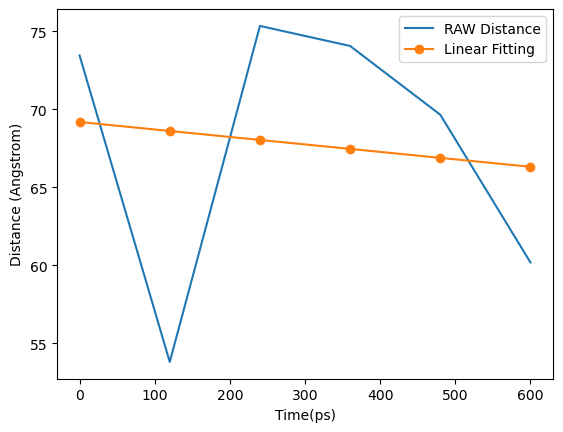

In [8]:
m_primo = Linear_Fitting('risultati/md_.pdb','Nuovi-MD/md.xtc',n=6,frame_rate=601)

# ALTERNATIVA

In alternativa abbiamo provato ad utilizzare il seguente codice per ricavare il file .xtc a partire dal file .tpr e .trr, ma procedendo con l'esecuzione della funzione Linear_Fitting, risulta che u.trajector è lungo solo "3".

In [ ]:
! echo -e "0 \n" | gmx trjconv -s PDB/3RFM_LIG/04-md/md.tpr -f PDB/3RFM_LIG/04-md/md.trr -pbc mol -o risultati/md.xtc -ur compact

In [ ]:
m_primo = Linear_Fitting('risultati/md.pdb','risultati/md.xtc',n=3,frame_rate=3)

# Codice per il run completo del suMD

In [ ]:
#Primo passo da NPT
#cpi no all'inizio

genius = 0
while genius == 0:
  print('\nInserisci numero step (compreso tra 3 e 302)') #step check 
  n = 5
  if int(n)<3:
    print('\nCon meno di tre step il metodo dei minimi quadrati non è applicabile, inserisci un numero più alto')
  elif int(n)>302:
    print('\nHai inserito un numero di step maggiore del numero di frame della simulazione\nOgni step deve durare almeno un frame, inserisci un numero più basso')
  else: 
    genius=1

t_step = 0
#m_primo = Preliminary_run(n) #simulazione preliminare MD (se m_primo < 0 non si entra nel preliminary run)

g_editconf('PDB/3RFM_LIG/04-md/md.tpr', 'risultati/md.pdb') # per avere il file pdb

m_primo = Linear_Fitting('risultati/md.pdb','PDB/3RFM_LIG/04-md/md.xtc',n,frame_rate=500)


"""
#PRELIMINARY RUN
while t_step < t_max and m_primo > 0:
  t_step += 1
  #Riassegnare velocità mantenendo la geometria
  m_primo = Preliminary_run(n)

  if m_primo < 0: #Uscita dal preliminary run
    break

  if t_step > t_max:
    t_step = 0
    #Riassegnare velocità e geometria

  if t_step == 1:
    print('OK')
    break


#suMD"""

